# Data Prep

In [14]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [15]:
# import data
pwd = os.getcwd()
filepath = os.path.join(pwd, "housing.csv")
housing_data = pd.read_csv(filepath)

In [16]:
# group income into categories
housing_data['income_cat'] = pd.cut(x=housing_data['median_income'], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels= [1, 2, 3, 4, 5])


In [17]:
# statified split based on the income categories 
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing_data, housing_data["income_cat"]):
    strat_train_set = housing_data.loc[train_index]
    strat_test_set = housing_data.loc[test_index]

In [18]:
# drop now unneccessary income_cat cols
strat_train_set.drop("income_cat", axis="columns", inplace=True)
strat_test_set.drop("income_cat", axis="columns", inplace=True)

In [19]:
# split data into input features and target output
#X = strat_train_set.drop("median_house_value", axis=1)
#y = strat_train_set["median_house_value"].copy()


In [20]:
# feature engineering function

def feature_engineering(data):
        data["bedrooms_per_household"] = data["total_bedrooms"] / data["households"]
        data["population_per_household"] = data["population"] / data["households"]
        data["rooms_per_household"] = data["total_rooms"] / data["households"]
        return data

In [21]:
# data transformation function

def data_transformations(data):

    if "median_house_value" in data.columns:
        labels = data["median_house_value"]
        data = data.drop("median_house_value", axis=1)

    else:
        labels = None

    # feature engineering
    feature_engineered_data = feature_engineering(data)
    features = list(feature_engineered_data.columns)

    # impute missing values
    imputer = SimpleImputer(strategy="median")
    data_num = feature_engineered_data.select_dtypes(include=[np.number])
    data_imputed = imputer.fit_transform(data_num)
    
    # encode categorical variables
    data_cat = feature_engineered_data.select_dtypes(exclude=[np.number])
    cat_encoder = OneHotEncoder(sparse=False)
    data_cat_1hot = cat_encoder.fit_transform(data_cat)

    features = features + cat_encoder.categories_[0].tolist()
    features.remove("ocean_proximity") # We're encoding this variable, so we don't need it in our list anymore

    # scaling
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_imputed)

    # concatenating data 
    output = np.hstack([data_scaled, data_cat_1hot])

    return output, labels, features

In [22]:
# applying transformation to train and test sets
X_train, y_train, features = data_transformations(strat_train_set)

X_test, y_test, features = data_transformations(strat_test_set)

# Model Testing

## Linear Regression

In [23]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression() # Create Linear Regression Object
lin_reg.fit(X_train, y_train)

LinearRegression()

## Decision Tree Regression

In [24]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

# Random Forest Regression

In [25]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.model_selection import GridSearchCV

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42)

params_rf = {
    'n_estimators': randint(low=1, high=200), # No of trees
    'max_depth': randint(low=1, high=15), # maximum depth to explore
    'min_samples_split':[5], # minimum samples required for split
    'min_samples_leaf':[5], # minimum samples required at leaf
    'max_features': ['auto'] # number of features for the best split
}

rnd_search_rf = RandomizedSearchCV(estimator = forest_reg, # regressor we want to use
                       param_distributions = params_rf, # Hyperparameter space
                       scoring ='neg_mean_squared_error', # MSE will be performance metric
                       cv = 5, # #of folds
                       n_iter=10,
                       random_state=42)

# fit the model
rnd_search_rf.fit(X_train, y_train)

In [ ]:
rnd_search_rf.best_estimator_

RandomForestRegressor(max_depth=13, min_samples_leaf=5, min_samples_split=5,
                      n_estimators=21, random_state=42)

In [ ]:
cvres = rnd_search_rf.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

57944.67954075505 {'max_depth': 7, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 180}
52533.45492466211 {'max_depth': 13, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 15}
52505.51853301992 {'max_depth': 11, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 72}
52272.57161714732 {'max_depth': 13, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 21}
57922.34784751652 {'max_depth': 7, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 122}
72684.98213861941 {'max_depth': 3, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 75}
52462.46120823257 {'max_depth': 11, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 88}
64106.837733946406 {'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_es

In [ ]:
param_grid = [
    # try 4 (4×1) combinations of hyperparameters
    {'n_estimators': [20, 25, 30, 35], 'max_features': ['auto']},
    # then try 4 (4×1) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [20, 25, 30, 35], 'max_features': ['auto']},
  ]

forest_reg = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': ['auto'],
                          'n_estimators': [20, 25, 30, 35]},
                         {'bootstrap': [False], 'max_features': ['auto'],
                          'n_estimators': [20, 25, 30, 35]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

51967.13669151316 {'max_features': 'auto', 'n_estimators': 20}
51707.8660985411 {'max_features': 'auto', 'n_estimators': 25}
51601.76770631035 {'max_features': 'auto', 'n_estimators': 30}
51460.23444314958 {'max_features': 'auto', 'n_estimators': 35}
68608.66945183206 {'bootstrap': False, 'max_features': 'auto', 'n_estimators': 20}
68596.46716221633 {'bootstrap': False, 'max_features': 'auto', 'n_estimators': 25}
68577.38985660193 {'bootstrap': False, 'max_features': 'auto', 'n_estimators': 30}
68555.6677391545 {'bootstrap': False, 'max_features': 'auto', 'n_estimators': 35}


Bootstrap should be kept TRUE. increasing n_estimators lowers the score. Let's run gridsearch again to see how high n_estimators can go before score worsens.

In [ ]:
param_grid = [

    {'n_estimators': [35, 40, 45, 50, 55, 60], 'max_features': ['auto']},
        
  ]

forest_reg = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': ['auto'],
                          'n_estimators': [35, 40, 45, 50, 55, 60]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

51460.23444314958 {'max_features': 'auto', 'n_estimators': 35}
51379.28031749228 {'max_features': 'auto', 'n_estimators': 40}
51311.21814606854 {'max_features': 'auto', 'n_estimators': 45}
51245.40545693655 {'max_features': 'auto', 'n_estimators': 50}
51170.37954886524 {'max_features': 'auto', 'n_estimators': 55}
51131.46273181215 {'max_features': 'auto', 'n_estimators': 60}


In [27]:
param_grid = [

    {'n_estimators': [600, 750, 800], 'max_features': ['auto']},
        
  ]

forest_reg = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': ['auto'],
                          'n_estimators': [600, 750, 800]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [28]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

50720.53696751803 {'max_features': 'auto', 'n_estimators': 600}
50711.686268065874 {'max_features': 'auto', 'n_estimators': 750}
50708.40828974005 {'max_features': 'auto', 'n_estimators': 800}


In [39]:
best_rf_model = grid_search.best_estimator_

## Ridge Regression

In [29]:
from sklearn.linear_model import Ridge

ridge = Ridge(random_state=42)

params_ridge = {
    'alpha': [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100], #L2 parameter space
    'solver': ['auto','saga','sag','cholesky']
}

grid_ridge = GridSearchCV(estimator = ridge, # regressor we want to use
                       param_grid = params_ridge, # Hyperparameter space
                       scoring ='neg_mean_squared_error',
                       cv = 3, # No of folds
                       verbose = 1,
                       n_jobs = -1) # use all cores

# fit the model
grid_ridge.fit(X_train, y_train)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


GridSearchCV(cv=3, estimator=Ridge(random_state=42), n_jobs=-1,
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.0009, 0.0007, 0.0005,
                                   0.0003, 0.0001, 0.001, 0.05, 0.01, 0.1, 0.3,
                                   1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100],
                         'solver': ['auto', 'saga', 'sag', 'cholesky']},
             scoring='neg_mean_squared_error', verbose=1)

In [30]:
# Defining CV Score function we will use to calculate the scores
def cv_score(score):
    rmse = np.sqrt(-score) # -score because we are using "neg_mean_squared_error" as our metric
    return (rmse)

print('CV Score for best RidgeRegressor model: {:.2f}'.format(cv_score(grid_ridge.best_score_)))

CV Score for best RidgeRegressor model: 69160.45


In [31]:
best_model_ridge = grid_ridge.best_estimator_

##  ElasticNet Regression

In [32]:
from sklearn.linear_model import ElasticNet

# Instantiate the Ridge Regressor
elastic = ElasticNet(random_state=42)

# Creating Parameter grid for GridSearch CV
params_elastic = {
    'alpha': [ 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15], #L2 regularization parameter space
    'l1_ratio': [0.01,0.1,0.3,0.5,0.8] #L1 regularization parameter space
}

# Instantiate grid search using GradientBoostingRegressor
grid_elastic = GridSearchCV(estimator = elastic, # regressor we want to use
                       param_grid = params_elastic, # Hyperparameter space
                       scoring ='neg_mean_squared_error',
                       cv = 3, # No of folds
                       verbose = 1,
                       n_jobs = -1) # use all cores

# fit the model
grid_elastic.fit(X_train, y_train)

Fitting 3 folds for each of 75 candidates, totalling 225 fits


GridSearchCV(cv=3, estimator=ElasticNet(random_state=42), n_jobs=-1,
             param_grid={'alpha': [0.0009, 0.0007, 0.0005, 0.0003, 0.0001,
                                   0.001, 0.05, 0.01, 0.1, 0.3, 1, 3, 5, 10,
                                   15],
                         'l1_ratio': [0.01, 0.1, 0.3, 0.5, 0.8]},
             scoring='neg_mean_squared_error', verbose=1)

In [33]:
print('CV Score for best ElasticNet model: {:.2f}'.format(cv_score(grid_elastic.best_score_)))

CV Score for best ElasticNet model: 69160.35


In [34]:
best_model_elastic = grid_elastic.best_estimator_

## XGBoost

In [35]:
import xgboost as xgb

# Instantiate the SVM Regressor
xgbr = xgb.XGBRegressor(objective='reg:linear')

# Creating Parameter grid for GridSearch CV
params_xgb = {
    'n_estimators': range(50, 800, 50)
}

# Instantiate grid search using GradientBoostingRegressor
grid_xgb = GridSearchCV(estimator = xgbr, # regressor we want to use
                       param_grid = params_xgb, # Hyperparameter space
                       scoring ='neg_mean_squared_error',
                       cv = 3, # No. of folds
                       verbose = 1,
                       n_jobs = -1) # use all cores

# fit the model
grid_xgb.fit(X_train, y_train)

c:\Users\aksc7\miniconda3\envs\sklearn-env\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Fitting 3 folds for each of 15 candidates, totalling 45 fits
[10:52:48] WARNING: c:\windows\temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None,
                                    objective='reg:linear', predictor=None,
                                    random_state=None, reg_alpha=None,
                       

In [36]:
cvres = grid_xgb.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

48807.0735705334 {'n_estimators': 50}
48445.99449491899 {'n_estimators': 100}
48504.679684689545 {'n_estimators': 150}
48445.51906659618 {'n_estimators': 200}
48485.583250452386 {'n_estimators': 250}
48531.413011462115 {'n_estimators': 300}
48561.12947477786 {'n_estimators': 350}
48576.87183617159 {'n_estimators': 400}
48601.2699336978 {'n_estimators': 450}
48624.32214846079 {'n_estimators': 500}
48647.39982984343 {'n_estimators': 550}
48657.391640747584 {'n_estimators': 600}
48660.795144112824 {'n_estimators': 650}
48665.02026606957 {'n_estimators': 700}
48677.00614502719 {'n_estimators': 750}


In [37]:
grid_xgb.best_params_

{'n_estimators': 200}

In [38]:
best_xgb_model = grid_xgb.best_estimator_

## Ensemble

In [40]:
from sklearn.ensemble import VotingRegressor

ereg = VotingRegressor(estimators = [('rf', best_rf_model), ('rd', best_model_ridge), ('el', best_model_elastic), ('xg', best_xgb_model)])
ereg = ereg.fit(X_train, y_train)

[10:54:48] WARNING: c:\windows\temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


In [41]:
from sklearn.model_selection import cross_val_score

ereg_scores = cross_val_score(ereg, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
ereg_rmse_scores = np.sqrt(-ereg_scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(ereg_rmse_scores)

[11:00:17] WARNING: c:\windows\temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[11:02:06] WARNING: c:\windows\temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[11:03:57] WARNING: c:\windows\temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[11:08:16] WARNING: c:\windows\temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[11:13:23] WARNING: c:\windows\temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[11:17:00] WARNING: c:\windows

Ensemble method didn't really improve the mean score, so will stick to XGBoost for the final model

## Feature Importance

In [43]:
feature_importances = best_xgb_model.feature_importances_
feature_importances

array([1.5224707e-02, 1.9090116e-02, 1.7720113e-02, 5.5376142e-03,
       6.2983762e-03, 6.3672545e-03, 9.9564120e-03, 1.4341114e-01,
       6.5574399e-03, 3.9025325e-02, 9.7093759e-03, 8.1816055e-03,
       6.6715109e-01, 3.3004192e-04, 2.8652228e-02, 1.6787173e-02],
      dtype=float32)

In [44]:
feature_importance_list = list(zip(features, feature_importances.tolist()))
feature_importance_list

[('longitude', 0.015224707312881947),
 ('latitude', 0.019090116024017334),
 ('housing_median_age', 0.017720112577080727),
 ('total_rooms', 0.0055376142263412476),
 ('total_bedrooms', 0.006298376247286797),
 ('population', 0.006367254536598921),
 ('households', 0.009956412017345428),
 ('median_income', 0.14341114461421967),
 ('bedrooms_per_household', 0.006557439919561148),
 ('population_per_household', 0.03902532532811165),
 ('rooms_per_household', 0.009709375910460949),
 ('<1H OCEAN', 0.008181605488061905),
 ('INLAND', 0.6671510934829712),
 ('ISLAND', 0.00033004191936925054),
 ('NEAR BAY', 0.02865222841501236),
 ('NEAR OCEAN', 0.016787173226475716)]

<BarContainer object of 16 artists>

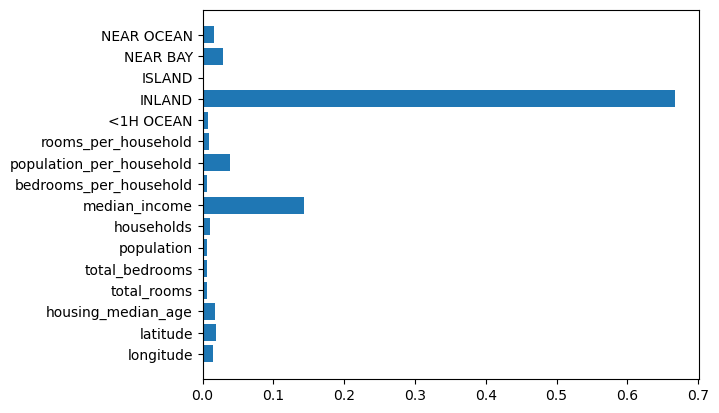

In [45]:
import matplotlib.pyplot as plt
plt.barh(y=features, width=feature_importances.tolist())

## Testing

In [47]:
final_model = best_xgb_model

final_predictions = final_model.predict(X_test)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

final_rmse

75256.98800654519

The difference in score shows that the model may have overfitted the training data. Further work will need to be done to tweak the model. On reflection, I should have included a validation set and compared the scored between both as I modified the hyperparameters.

## Model Export

In [42]:
import pickle
pickle.dump(best_xgb_model, open('house_model_xgb.pkl', 'wb'))